In [1]:
from PIL import Image
from numpy import *
from pylab import *
import ransac
import sift
from PIL import Image
import homography
import warp
from scipy import ndimage

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def Hsimilarity_from_points(fp, tp):
    """ Find similarity transformation, such that fp is mapped to tp
    using the linear DLT method. Points are conditioned
    automatically. """

    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')

    # Condition points (important for numerical reasons)
    # --from points--
    m = mean(fp[:2], axis=1)
    maxstd = max(std(fp[:2], axis=1)) + 1e-9
    C1 = diag([1/maxstd, 1/maxstd, 1])
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp = dot(C1, fp)

    # -- to points --
    m = mean(tp[:2], axis=1)
    maxstd = max(std(tp[:2], axis=1)) + 1e-9
    C2 = diag([1/maxstd, 1/maxstd, 1])
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp = dot(C2, tp)

    # create matrix for linear method
    # Start from similarity transformation,
    # [x', y', 1].T = [[c, -s, tx], [s, c, ty], [0, 0, 1]] * [x, y, 1]
    # c = a*cos(t)
    # s = a*sin(t)
    # this can be extended to 
    # [[(x*y'-y*x'), -(x*x'+y*y'), y', -x']*[c, s, tx, ty]=[0, 0, 0].T
    # (.T is transverse)
    # By solving this for [(x, y, x', y') = [[x1, y1, x1', y1'], [x2, y2, x2', y2'], ...]
    # You can get c, s, tx, ty : similarity matrix
    nbr_correspondences = fp.shape[1]
    A = zeros((nbr_correspondences, 4))
    for i in range(nbr_correspondences):
        A[i] = [fp[0][i]*tp[1][i]-fp[1][i]*tp[0][i], -fp[0][i]*tp[0][i]-fp[1][i]*tp[1][i], tp[1][i], -tp[0][i]]
        U, S, V = linalg.svd(A)
        H = [[V[3][0], -V[3][1], V[3][2]], [V[3][1], V[3][0], V[3][3]], [0, 0, 1]]
        # V[3] has the smallest singlarity value = smallest error in least square method
    # decondition (C1, C2)
    H = dot(linalg.inv(C2), dot(H, C1))

    # normalize and return
    return H

In [3]:
class RansacModel_2(object):
    """ Class for testing homography fit with ransac.py from
    http://www.scipy.org/Cookbook/RANSAC
    This version uses Similarity Transformation 
    """

    def __init__(self, debug=False):
        self.debug = debug

    def fit(self, data):
        """ Fit homography to four selected correspondences. """

        data = data.T

        fp = data[:3, :4]

        tp = data[3:, :4]

        return Hsimilarity_from_points(fp,tp)

    def get_error(self, data, H):
        """ Apply homography to all correspondences,
        return error for each transformed point."""

        data = data.T

        fp = data[:3]
        tp = data[3:]


        fp_transformed = dot(H, fp)

        #
        nz = nonzero(fp_transformed[2])
        for i in range(3):
            fp_transformed[i][nz] /= fp_transformed[2][nz]

        return sqrt(sum((tp-fp_transformed)**2, axis=0))

In [4]:
# use the test data here
# http://www.cs.cornell.edu/courses/cs6670/2011sp/projects/p2/project2.html

featname = ['campus_0'+('0' if (i<10) else '')+str(i)+'.sift' for i in range(18)]
imname = ['campus_0'+('0' if (i<10) else '')+str(i)+'.jpg' for i in range(18)]
l = {}
d = {}
for i in range(18):
    sift.process_image(imname[i],featname[i])
    l[i],d[i] = sift.read_features_from_file(featname[i])
    l[i][:,[0,1]] = l[i][:,[1,0]]
    
matches = {}
for i in range(18):
    matches[i] = sift.match(d[(i+1)%18],d[i])

processed tmp.pgm to campus_000.sift
processed tmp.pgm to campus_001.sift
processed tmp.pgm to campus_002.sift
processed tmp.pgm to campus_003.sift
processed tmp.pgm to campus_004.sift
processed tmp.pgm to campus_005.sift
processed tmp.pgm to campus_006.sift
processed tmp.pgm to campus_007.sift
processed tmp.pgm to campus_008.sift
processed tmp.pgm to campus_009.sift
processed tmp.pgm to campus_010.sift
processed tmp.pgm to campus_011.sift
processed tmp.pgm to campus_012.sift
processed tmp.pgm to campus_013.sift
processed tmp.pgm to campus_014.sift
processed tmp.pgm to campus_015.sift
processed tmp.pgm to campus_016.sift
processed tmp.pgm to campus_017.sift


In [5]:
def convert_points(j):
    ndx = matches[j].nonzero()[0]
    fp = homography.make_homog(l[(j+1)%18][ndx, :2].T)
    ndx2 = [int(matches[j][i]) for i in ndx]
    tp = homography.make_homog(l[j][ndx2,:2].T)
    return fp, tp

In [21]:
model = RansacModel_2()

#H = [[[0,0,0],[0,0,0],[0,0,0]] for i in range(18)]
H = []
for i in range(18):
    fp, tp = convert_points(i)
    H.append(homography.H_from_ransac(fp, tp, model)[0]) #im1 to im2

From 0 to 17

warp - right


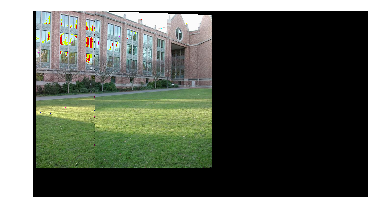

From 17 to 16

warp - right


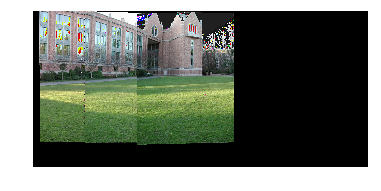

From 16 to 15

warp - right


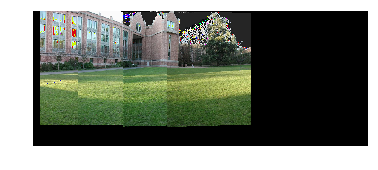

From 15 to 14

warp - right


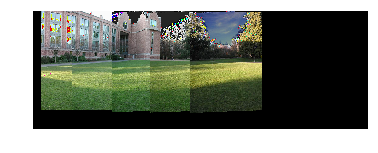

From 14 to 13

warp - right


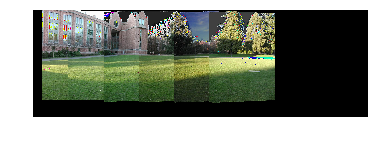

From 13 to 12

warp - right


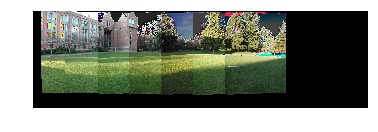

From 12 to 11

warp - right


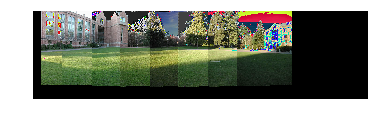

From 11 to 10

warp - right


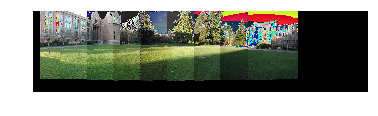

From 10 to 9

warp - right


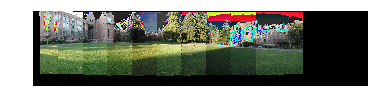

From 9 to 8

warp - right


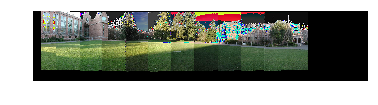

From 8 to 7

warp - right


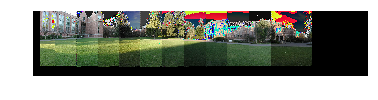

From 7 to 6

warp - right


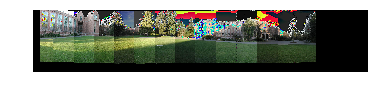

From 6 to 5

warp - right


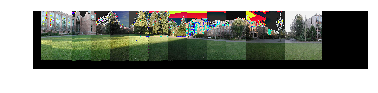

From 5 to 4

warp - right


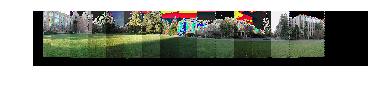

From 4 to 3

warp - right


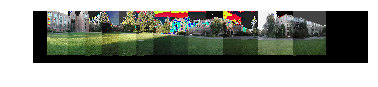

From 3 to 2

warp - right


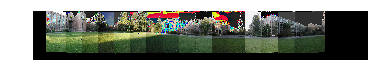

From 2 to 1

warp - right


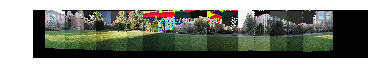

From 1 to 0

warp - right


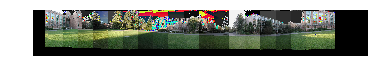

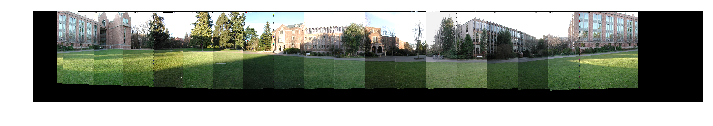

In [54]:
delta = 480
st = 18
vdelta = 120
im1 = array(Image.open(imname[st%18]))
im1 = 128.0*im1/np.average(im1)
im1 = vstack((im1, zeros((vdelta, im1.shape[1], im1.shape[2]))))
#im1 = vstack((zeros((vdelta, im1.shape[1], im1.shape[2])), im1))

def transf(p):
    p2 = dot(H, [p[0], p[1], 1])
    return (p2[0]/p2[2], p2[1]/p2[2])

ty = 0
tx = 0
H1 = array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
delta = 640
for i in range(st, 0, -1):
    i = i % 18
    j = i-1 if (i>0) else 18+i-1
    print "From "+str(i)+" to "+str(j)+"\n"
    im2 = array(Image.open(imname[j]))
    [m, n, c] = im2.shape
    im2 = 128.0*im2/np.average(im2)
    im2 = vstack((im2, zeros((vdelta, n, im2.shape[2]))-100))
    H1 = dot(H[j], H1)
    delta = uint16(640 - (im1.shape[1] + H1[1][2] - 480))
    delta = 0 if (delta<0) else delta
    im0 = zeros(im1.shape)-100
    im2 = warp.panorama(H1, im2, im0, delta, delta)
    im1 = hstack((im1, zeros((im1.shape[0], delta, 3))))

    # Adjust the perspective 
    # [m, n, c] = im2.shape
    op = array([[0, 0, m, m], [0, n, n, 0], [1, 1, 1, 1]])
    fp = dot(inv(H1), op)
    tx = math.sqrt((fp[0][1]-fp[0][0])**2 + (fp[1][1]-fp[1][0])**2)
    tp = array([[fp[0][0], op[0][1], op[0][2], fp[0][3]], [fp[1][0], fp[1][0]+tx, fp[1][0]+tx, fp[1][3]], [1, 1, 1, 1]])

    tp2 = tp[:, [0, 2, 3]]
    fp2 = fp[:, [0, 2, 3]]
    H2 = homography.Haffine_from_points(tp2, fp2)
    im3 = zeros(im1.shape)
    for c in range(3):
        im3[:,:,c] = ndimage.affine_transform(im2[:,:,c], H2[:2,:2], (H2[0,2], H2[1,2]), im1.shape[:2])
    
    tp2 = tp[:, [0, 1, 2]]
    fp2 = fp[:, [0, 1, 2]]
    H2 = homography.Haffine_from_points(tp2, fp2)
    im4 = zeros(im1.shape)
    for c in range(3):
        im4[:,:,c] = ndimage.affine_transform(im2[:,:,c], H2[:2,:2], (H2[0,2], H2[1,2]), im1.shape[:2])
   
    im1[im3>=0] = im3[im3>=0]
    im1[im4>=0] = im4[im4>=0]

    H1 = dot(H1, H2)
    imshow(uint8(im1))
    axis('off')
    show()    

im1[im1<0] = 0
im1[im1>255] = 255
im1 = uint8(im1)

figure(figsize=(12,12))
imshow(uint8(im1))
axis('off')
show()

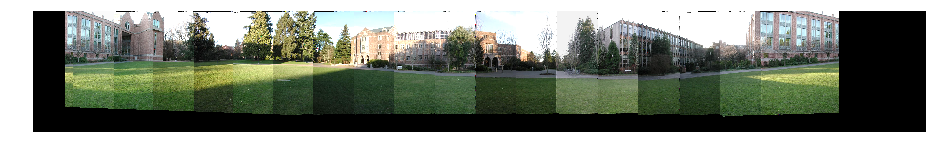

In [55]:
figure(figsize=(16,16))
imshow(uint8(im1))
axis('off')
show()